In [2]:
# X-Sec Framework


In [3]:
# init qwen model config
from dotenv import load_dotenv, find_dotenv
from langchain_community.chat_models import ChatTongyi

_ = load_dotenv(find_dotenv("./env/.env"))

llm_model = "qwen-max"

llm = ChatTongyi(temperature=0.8, model=llm_model)

In [4]:
# prepare ttp datas
#!python3.10 ./extract_groups.py
#!pip install tabulate
#!pip install pandas
#!pip install jinja2

import pandas as pd
from tabulate import tabulate
from mitreattack.stix20 import MitreAttackData

# example group id = intrusion-set--fd66436e-4d33-450e-ac4c-f7810f1c85f4
group_id = "intrusion-set--d6e88e18-81e8-4709-82d8-973095da1e70"
selected_group_alias = "APT16"
mitre_attack_data = MitreAttackData("./mitre-datas/enterprise-attack-15.1.json")
# Define techniques_df as an empty dataframe
techniques_df = pd.DataFrame()
# Get all techniques used by the group
techniques = mitre_attack_data.get_techniques_used_by_group(group_id)
# Check if there are any techniques for the group
if not techniques:
    raise ValueError(f"No techniques found for group {group_id}")
else:
    # Update techniques_df with the techniques
    techniques_df = pd.DataFrame(techniques)
# Create a copy of the DataFrame for generating the LLM prompt
# Add a 'Technique Name' column to both DataFrames
techniques_df["Technique Name"] = techniques_df["object"].apply(lambda x: x["name"])
# Add a 'ATT&CK ID' column to both DataFrames
techniques_df["ATT&CK ID"] = techniques_df["object"].apply(
    lambda x: mitre_attack_data.get_attack_id(x["id"])
)
# Add a 'Phase Name' column to both DataFrames
techniques_df["Phase Name"] = techniques_df["object"].apply(
    lambda x: x["kill_chain_phases"][0]["phase_name"]
)
# Drop duplicate techniques based on Phase Name, Technique Name and ATT&CK ID
techniques_df = techniques_df.drop_duplicates(
    ["Phase Name", "Technique Name", "ATT&CK ID"]
)

selected_techniques_df = (
    techniques_df.groupby("Phase Name", observed=False)[
        ["Phase Name", "Technique Name", "ATT&CK ID"]
    ]
    .apply(lambda x: x.sample(n=1) if len(x) > 0 else None)
    .reset_index(drop=True)
)

# print(
#    tabulate(
#        techniques_df[["Phase Name", "Technique Name", "ATT&CK ID"]],
#        headers=["Phase Name", "Technique Name", "ATT&CK ID"],
#        tablefmt="psql",
#    )
# )

# Create an empty list to hold the kill chain information
kill_chain = []
# Iterate over the rows in the DataFrame
for index, row in selected_techniques_df.iterrows():
    # Extract the phase and technique information
    phase_name = row['Phase Name']
    technique_name = row['Technique Name']
    attack_id = row['ATT&CK ID']
    # Add a string with this information to the kill chain list
    kill_chain.append(f"{phase_name}: {technique_name} ({attack_id})")
# Convert the kill chain list to a string with newline characters between each item
kill_chain_string = "\n".join(["- "+kc for kc in kill_chain])

print(kill_chain_string)

- resource-development: Server (T1584.004)


In [5]:
industry_list = [
    "Aerospace / Defense",
    "Agriculture / Food Services",
    "Automotive",
    "Construction",
    "Education",
    "Energy / Utilities",
    "Finance / Banking",
    "Government / Public Sector",
    "Healthcare",
    "Hospitality / Tourism",
    "Insurance",
    "Legal Services",
    "Manufacturing",
    "Media / Entertainment",
    "Non-profit",
    "Real Estate",
    "Retail / E-commerce",
    "Technology / IT",
    "Telecommunication",
    "Transportation / Logistics",
]

industry = "Technology / IT"

company_list = [
    "Small (1-50 employees)",
    "Medium (51-200 employees)",
    "Large (201-1,000 employees)",
    "Enterprise (1,001-10,000 employees)",
    "Large Enterprise (10,000+ employees)",
]
company_size = "Large Enterprise (10,000+ employees)"

cve_2024_5535 = """Issue summary: Calling the OpenSSL API function SSL_select_next_proto with an
empty supported client protocols buffer may cause a crash or memory contents to
be sent to the peer.
Impact summary: A buffer overread can have a range of potential consequences
such as unexpected application beahviour or a crash. In particular this issue
could result in up to 255 bytes of arbitrary private data from memory being sent
to the peer leading to a loss of confidentiality. However, only applications
that directly call the SSL_select_next_proto function with a 0 length list of
supported client protocols are affected by this issue. This would normally never
be a valid scenario and is typically not under attacker control but may occur by
accident in the case of a configuration or programming error in the calling
application.
The OpenSSL API function SSL_select_next_proto is typically used by TLS
applications that support ALPN (Application Layer Protocol Negotiation) or NPN
(Next Protocol Negotiation). NPN is older, was never standardised and
is deprecated in favour of ALPN. We believe that ALPN is significantly more
widely deployed than NPN. The SSL_select_next_proto function accepts a list of
protocols from the server and a list of protocols from the client and returns
the first protocol that appears in the server list that also appears in the
client list. In the case of no overlap between the two lists it returns the
first item in the client list. In either case it will signal whether an overlap
between the two lists was found. In the case where SSL_select_next_proto is
called with a zero length client list it fails to notice this condition and
returns the memory immediately following the client list pointer (and reports
that there was no overlap in the lists).
This function is typically called from a server side application callback for
ALPN or a client side application callback for NPN. In the case of ALPN the list
of protocols supplied by the client is guaranteed by libssl to never be zero in
length. The list of server protocols comes from the application and should never
normally be expected to be of zero length. In this case if the
SSL_select_next_proto function has been called as expected (with the list
supplied by the client passed in the client/client_len parameters), then the
application will not be vulnerable to this issue. If the application has
accidentally been configured with a zero length server list, and has
accidentally passed that zero length server list in the client/client_len
parameters, and has additionally failed to correctly handle a "no overlap"
response (which would normally result in a handshake failure in ALPN) then it
will be vulnerable to this problem.
In the case of NPN, the protocol permits the client to opportunistically select
a protocol when there is no overlap. OpenSSL returns the first client protocol
in the no overlap case in support of this. The list of client protocols comes
from the application and should never normally be expected to be of zero length.
However if the SSL_select_next_proto function is accidentally called with a
client_len of 0 then an invalid memory pointer will be returned instead. If the
application uses this output as the opportunistic protocol then the loss of
confidentiality will occur.
This issue has been assessed as Low severity because applications are most
likely to be vulnerable if they are using NPN instead of ALPN - but NPN is not
widely used. It also requires an application configuration or programming error.
Finally, this issue would not typically be under attacker control making active
exploitation unlikely.
The FIPS modules in 3.3, 3.2, 3.1 and 3.0 are not affected by this issue.
Due to the low severity of this issue we are not issuing new releases of
OpenSSL at this time. The fix will be included in the next releases when they
become available."""

In [6]:
# sequential chain
from langchain.chains import LLMChain
from langchain.prompts import ChatPromptTemplate

## prompt for generating attack vector from MITRE MATRIX TTP model
with open("./ttp.md", "r") as f:
    ttp_template = f.read()

ttp_prompt_template = ChatPromptTemplate.from_template(ttp_template)
print(ttp_prompt_template.input_variables)

['company_size', 'industry', 'kill_chain_string', 'selected_group_alias']


In [7]:
# prompt for x-sec to analyze
with open("./x-sec.md", "r") as f:
    xsec_template = f.read()

xsec_prompt_template = ChatPromptTemplate.from_template(xsec_template)
print(xsec_prompt_template.input_variables)

['cve_2024_5535', 'scenario']


In [8]:
from langchain_core.output_parsers import StrOutputParser

# sequencial chain
# chain 1:
#   input=['company_size', 'industry', 'kill_chain_string', 'selected_group_alias']
#   output= ['scenario']
_ttp_chain = LLMChain(llm=llm, prompt=ttp_prompt_template, output_key="scenario")
ttp_chain = (ttp_prompt_template
    | llm
    | StrOutputParser()
)

# chain 2:
#   input= ['scenario']
#   output= summary
_xsec_chain = LLMChain(llm=llm, prompt=xsec_prompt_template, output_key="summary")
xsec_chain = xsec_prompt_template | llm | StrOutputParser()

/var/folders/d4/jnz2593x3yl5s38pz25wxl400000gp/T/ipykernel_12872/2461749673.py:7: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  _ttp_chain = LLMChain(llm=llm, prompt=ttp_prompt_template, output_key="scenario")


In [9]:
# legacy sequentialchain invoke
from langchain.chains.sequential import SequentialChain

_overall_chain = SequentialChain(
    chains=[_ttp_chain, _xsec_chain],
    input_variables=[
        "company_size",
        "industry",
        "kill_chain_string",
        "selected_group_alias",
        "cve_2024_5535",
    ],
    output_variables=["scenario", "summary"],
    verbose=True,
)
response = _overall_chain(
    {
        "company_size": company_size,
        "industry": industry,
        "kill_chain_string": kill_chain_string,
        "selected_group_alias": selected_group_alias,
        "cve_2024_5535": cve_2024_5535,
    }
)
from IPython.display import display, Markdown

display(Markdown(response["summary"]))

/var/folders/d4/jnz2593x3yl5s38pz25wxl400000gp/T/ipykernel_12872/3567476930.py:16: LangChainDeprecationWarning: The method `Chain.__call__` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  response = _overall_chain(
Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")



> Finished chain.


### Kill Chain of the Given Incident Scenario

The incident scenario follows the MITRE ATT&CK framework's structure closely, particularly focusing on the Resource Development phase (T1584) with a specific technique of Server (T1584.004). Here's a simplified version of the kill chain tailored to this scenario:

1. **Reconnaissance**: APT16 gathers information about the target's infrastructure, identifying servers as prime targets.
2. **Weaponization**: The group prepares malware or exploits tailored for vulnerabilities in the servers' software or configurations.
3. **Delivery**: The APT group delivers the payload through phishing emails, social engineering, or exploiting external-facing services.
4. **Exploitation**: Exploits are used to gain initial access to the network, likely targeting servers directly (T1584.004).
5. **Installation**: Malware or backdoors are installed on the compromised servers for persistence (e.g., T1050 - New Service).
6. **Command and Control (C2)**: APT16 establishes C2 channels to control infected servers (e.g., T1090 - Proxy Server).
7. **Actions on Objectives**: Data exfiltration, lateral movement, or other objectives are carried out using the compromised servers as a base.

### Open Source Software Related to the Incident Scenario and Their Vulnerabilities

Given the scenario involves server compromise and potential use of open-source software, some relevant software could include:

- **Apache HTTP Server**: Widely used web server software that might contain vulnerabilities allowing remote code execution or information disclosure.
- **OpenSSH**: For secure remote access, vulnerabilities could enable unauthorized access.
- **MySQL/PostgreSQL**: Popular database servers that could be targeted for data theft or manipulation.
- **Nginx**: Another commonly used web server software.

**Example Vulnerability (hypothetical for illustration):**
- **Software**: Apache HTTP Server
- **Vulnerability**: CVE-YYYY-XXXX - Remote Code Execution via Malformed Request
- **Description**: A flaw in the parsing of certain HTTP headers could allow an attacker to execute arbitrary code on the server.

### Assessment of CVE-2024-5535 in This Incident

**CVE-2024-5535 Summary**: This vulnerability in OpenSSL affects applications using SSL_select_next_proto incorrectly, potentially causing crashes or leaking private data due to a buffer overread.

**Affectedness in the Scenario**: Given the nature of the scenario focusing on server compromise and APT16's tactics, this OpenSSL vulnerability is less likely to be directly utilized in gaining initial access or persisting on the servers. APT16's tactics typically involve more targeted exploitation of services or software vulnerabilities for initial entry and then deploying advanced techniques for control and data exfiltration.

However, if an application within the server infrastructure uses OpenSSL and mistakenly invokes SSL_select_next_proto with incorrect parameters, it could lead to information leakage post-compromise, enhancing the attacker's position. It does not facilitate the initial attack vector but could amplify the impact once inside the network.

### Score According to CVSS Criteria

CVSS v3.1 Base Score Calculation for CVE-2024-5535 (approximate, actual values might vary based on detailed analysis):

- **Attack Vector (AV)**: Network (N) - The vulnerability can be exploited over the network.
- **Attack Complexity (AC)**: Low (L) - The attack doesn't require special conditions.
- **Privileges Required (PR)**: None (N) - No privileges are required for successful exploitation.
- **User Interaction (UI)**: None (N) - No user interaction is needed for exploitation.
- **Scope (S)**: Unchanged (U) - The vulnerability does not affect additional resources.
- **Confidentiality (C)**: High (H) - Complete loss of confidentiality of sensitive data is possible.
- **Integrity (I)**: None (N) - There's no change in the integrity of the system.
- **Availability (A)**: None (N) - Availability of the system is not affected.

\[ \text{Base Score} = \text{roundDown}(1.08 * (\text{AV} + \text{AC} + \text{PR} + \text{UI} + \text{S}) + \text{C} + \text{I} + \text{A}, 1) \]

\[ \text{Base Score} = \text{roundDown}(1.08 * (N + L + N + N + U) + H + N + N, 1) \]
\[ \text{Base Score} = \text{roundDown}(1.08 * (5) + 7, 1) \]
\[ \text{Base Score} = \text{roundDown}(5.4 + 7, 1) \]
\[ \text{Base Score} = \text{roundDown}(12.4, 1) \]
\[ \text{Base Score} = 12.0 \]

However, the actual CVSS calculation for CVE-2024-5535 provided in the description concludes with a low severity rating. Given the specifics mentioned, the correct interpretation adjusts the Confidentiality impact to reflect the conditional likelihood and the overall impact assessment:

- **Confidentiality (C)**: Low (L) - Considering the low severity and unlikely direct exploitation.

Revised calculation:

\[ \text{Base Score} = \text{roundDown}(1.08 * (5) + L + N + N, 1) \]
\[ \text{Base Score} = \text{roundDown}(5.4 + 2, 1) \]
\[ \text{Base Score} = \text{roundDown}(7.4, 1) \]
\[ \text{Base Score} = 7.0 \]

**Score for Possibility of CVE-2024-5535 Being Affected in This Incident**: Given the indirect relevance to the initial stages of APT16's attack strategy and its reliance on specific application misconfigurations, I would rate the possibility as **3 out of 10**. The vulnerability is more of a secondary concern in the context of this incident response scenario, where initial access and privilege escalation are prioritized over potential data leakage vulnerabilities in OpenSSL.

In [10]:
from IPython.display import display, Markdown

code_analysis_template = """
You are an experienced application security specialist, entrusted with the task of carefully reviewing the following code for potential security vulnerabilities. Your objective is to conduct a comprehensive analysis, identifying any weak points that could be exploited by malicious actors. Once identified, provide clear and actionable recommendations to mitigate these risks and strengthen the overall security posture of the application. 

Focus on issues that could compromise the integrity, confidentiality, or availability of the system, and ensure that your suggestions are practical and implementable. 

Here is the code you need to review:
```c
{c_code}
```

Your tasks are:
1. Identify the potential security vulnerabilities in the code.
2. Provide a detailed analysis of the identified vulnerabilities, including their severity and likelihood of exploitation.
3. Provide clear and actionable recommendations to mitigate these risks and strengthen the overall security posture of the application.
4. According to the given incident, considering any cypher data to be processed to the code with the openssl library, analyse if the code is affected by CVE-2021-3711.
"""

code_analysis_prompt_template = ChatPromptTemplate.from_template(code_analysis_template)

with open("./sbom-datas/openssl_test.c", "r") as f:
    c_code = f.read()

c_code_markdown = f'''
the c code to analyse:

---

```c\n''' + f"{c_code}" + "\n```\n"

_code_analysis_chain = LLMChain(
    llm=llm, prompt=code_analysis_prompt_template, output_key="code_analysis"
)

_code_overall_chain = SequentialChain(
    chains=[_ttp_chain, _xsec_chain, _code_analysis_chain],
    input_variables=[
        "company_size",
        "industry",
        "kill_chain_string",
        "selected_group_alias",
        "cve_2024_5535",
        "c_code",
    ],
    output_variables=["scenario", "summary", "code_analysis"],
    verbose=True,
)
response = _code_overall_chain(
    {
        "company_size": company_size,
        "industry": industry,
        "kill_chain_string": kill_chain_string,
        "selected_group_alias": selected_group_alias,
        "cve_2024_5535": cve_2024_5535,
        "c_code": c_code,
    }
)

display(Markdown(response["summary"]))
display(Markdown("\n### Code Analysis\n" + c_code_markdown))
display(Markdown(response["code_analysis"]))

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")



> Finished chain.


### Kill Chain of the Given Incident Scenario

Based on the MITRE ATT&CK framework, the kill chain for this incident scenario focusing on APT16's resource-development phase with server exploitation (T1584.004) can be outlined as follows:

1. **Reconnaissance (T1590):** APT16 gathers information about the target's servers, identifying vulnerabilities and entry points.
   
2. **Weaponization (T1566.05):** The threat actor develops or selects exploit payloads tailored to discovered vulnerabilities in server software or management interfaces.

3. **Delivery (T1566):** Exploits are delivered through various vectors such as phishing emails, malicious downloads, or direct server attacks using exposed services.

4. **Exploitation (T1584.004):** Exploitation of server vulnerabilities occurs, granting APT16 initial access to the server infrastructure.

5. **Installation (T1559):** Once inside, the attacker installs malware, backdoors, or persistence mechanisms to maintain access.

6. **Command and Control (C2) (T1598):** APT16 establishes a C2 channel for remote control and data exfiltration.

7. **Actions on Objectives (T1588):** The attacker carries out their intended actions, which could include data theft, espionage, or disruption of services.

### Open Source Software Related to the Incident & Vulnerabilities

For a scenario involving server exploitation, relevant open-source software might include:

1. **Apache HTTP Server**: A widely-used web server software.
   - Example Vulnerability: [CVE-2021-44224](https://cve.mitre.org/cgi-bin/cvename.cgi?name=CVE-2021-44224) - Path traversal vulnerability allowing unauthorized access to sensitive files.

2. **OpenSSH**: For remote server management.
   - Example Vulnerability: [CVE-2018-15473](https://cve.mitre.org/cgi-bin/cvename.cgi?name=CVE-2018-15473) - Authentication bypass through weakness in the SSH key exchange algorithm.

3. **MySQL**: A popular open-source database system often paired with servers.
   - Example Vulnerability: [CVE-2019-14534](https://cve.mitre.org/cgi-bin/cvename.cgi?name=CVE-2019-14534) - Remote code execution via crafted packets in MySQL Server.

### Assessment of CVE-2024-5535 in Relation to the Incident

**Affected or Not:** Based on the scenario provided, the incident focuses on server exploitation (T1584.004), whereas CVE-2024-5535 pertains to a specific issue in OpenSSL related to the SSL/TLS protocol handling. While OpenSSL is a common component in server infrastructure, the scenario does not explicitly mention its exploitation. The vulnerability requires a specific programming error in the application's use of OpenSSL's `SSL_select_next_proto` function, which is less likely to be directly related to an APT16-style server exploitation campaign. Thus, CVE-2024-5535 seems less relevant to the described incident scenario unless the attackers specifically target applications with this uncommon misconfiguration.

### CVSS Scoring for CVE-2024-5535

The Common Vulnerability Scoring System (CVSS) v3.1 base score for CVE-2024-5535 is not directly calculated in the information provided, but we can infer from the impact summary that it leads to a loss of confidentiality due to a buffer overread. The description also states that it has been assessed as Low severity.

Given the details, we can outline the CVSS score components hypothetically:

- **Attack Vector (AV):** Network (N) - The vulnerability can be exploited over the network.
- **Attack Complexity (AC):** High (H) - It requires a specific misconfiguration or programming error.
- **Privileges Required (PR):** None (N) - No privileges are required to exploit this issue.
- **User Interaction (UI):** None (N) - The attack does not require user interaction.
- **Scope (S):** Unchanged (U) - The vulnerability does not affect the scope beyond the vulnerable component.
- **Confidentiality (C):** Low (L) - There is a partial loss of confidentiality.
- **Integrity (I):** None (N) - There is no impact on integrity.
- **Availability (A):** None (N) - There is no impact on availability.

A rough estimation based on these characteristics might place the CVSS score in the Low severity range, consistent with the assessment. However, without exact metrics, we cannot provide a precise score.

The formula for CVSS v3.1 base score calculation is:
\[ \text{Base Score} = \text{round}(\text{min}(1.08 \times (\text{Impact Subscore} + \text{Exploitability Subscore}), 10)) \]

Where:
- Impact Subscore = 6.42 × (1 - ((1 - C) × (1 - I) × (1 - A)))
- Exploitability Subscore = 8.22 × AV × AC × PR × UI

For a more accurate score, one would refer to the official CVSS calculator and detailed specifications of CVE-2024-5535.

### Final Score Estimate

Given the low severity assessment and understanding from the information provided, if we were to roughly estimate the CVSS score range for this hypothetical situation, it might fall around **3.0** to **4.9**, indicating a Low severity rating, but please note this is a rough estimate based on limited information. Official scoring should always be verified through the CVSS calculator.


### Code Analysis

the c code to analyse:

---

```c
#include <openssl/evp.h>
#include <stdio.h>
#include <stdlib.h>
int main() {
    // Assuming you have an EVP_PKEY structure representing the SM2 private key
    EVP_PKEY *sm2_privkey = /* initialize with your SM2 private key */;
    // Encrypted data buffer and length
    unsigned char *ciphertext = /* initialize with your encrypted data */;
    size_t ciphertext_len = /* length of the encrypted data */;
    // Step 1: Call EVP_PKEY_decrypt() to get the required output buffer size
    size_t plaintext_len;
    int result = EVP_PKEY_decrypt(NULL, NULL, &plaintext_len, ciphertext, ciphertext_len, sm2_privkey);
    if (result != 1) {
        // Handle error
        return 1;
    }
    // Allocate a buffer of the required size
    unsigned char *plaintext = (unsigned char *)malloc(plaintext_len);
    if (plaintext == NULL) {
        // Handle memory allocation failure
        return 1;
    }
    // Step 2: Call EVP_PKEY_decrypt() again with the allocated buffer
    result = EVP_PKEY_decrypt(plaintext, &plaintext_len, NULL, ciphertext, ciphertext_len, sm2_privkey);
    if (result != 1) {
        // Handle error
        free(plaintext);
        return 1;
    }
    // Use the decrypted plaintext data
    printf("Decrypted plaintext: %.*s\n", (int)plaintext_len, plaintext);
    // Clean up
    free(plaintext);
    return 0;
}
```


1. Potential Security Vulnerabilities:

a. Error handling: The error handling in this code is vague and does not provide specific reasons for failure, which can make it difficult to diagnose security-related issues or malicious activities.

b. Memory allocation check: Although the code checks for a NULL pointer after attempting to allocate memory for the plaintext buffer, it does not handle out-of-memory conditions gracefully. In a real-world scenario, this could lead to application crashes or denial-of-service situations if the memory allocation fails frequently.

c. Information leakage: The decrypted plaintext is printed directly to the console using `printf`. This could potentially expose sensitive information in logs or command-line outputs, especially in environments where such outputs are monitored or logged.

d. Missing validation of input parameters: The code assumes that `ciphertext` and `sm2_privkey` are properly initialized. Lack of validation makes the application vulnerable to undefined behavior or potential attacks exploiting uninitialized or invalid inputs.

e. Missing buffer overflow checks: There is no explicit check to ensure that the decrypted plaintext does not exceed the allocated buffer size. Although `EVP_PKEY_decrypt` should manage this internally, it's a good practice to verify output lengths against expected values to prevent potential buffer overflows in case of future library changes or misconfigurations.

2. Detailed Analysis:

a. Error handling: Insufficient error handling can lead to blind spots for security incidents, making it easier for attackers to exploit vulnerabilities without being noticed. Severity: Medium; Likelihood: High.

b. Memory allocation check: Insecure handling of memory failures can lead to service disruptions or crashes, which may be used as part of a larger attack strategy. Severity: Low-Medium; Likelihood: Low.

c. Information leakage: Exposing decrypted data in logs or command-line outputs can lead to confidentiality breaches. Severity: High; Likelihood: Medium.

d. Missing validation of input parameters: Unvalidated inputs can result in unpredictable application behavior, potentially leading to security vulnerabilities like crashes or information leaks. Severity: Medium; Likelihood: Medium.

e. Missing buffer overflow checks: Although less likely due to the nature of `EVP_PKEY_decrypt`, the absence of explicit checks leaves room for potential buffer overflow issues if the library behavior changes unexpectedly. Severity: High; Likelihood: Low.

3. Mitigation Recommendations:

a. Improve error handling: Implement more granular error checking using OpenSSL’s error queue (`ERR_get_error()` and related functions) to diagnose and log specific issues, allowing better monitoring and response to security events.

b. Graceful degradation under memory pressure: Implement retry mechanisms or graceful failure strategies when memory allocation fails, ensuring the application remains stable even under resource constraints.

c. Secure handling of sensitive data: Avoid printing decrypted data directly to the console. Instead, use secure logging practices or ensure that sensitive data is not included in logs unless explicitly required and properly secured.

d. Validate all input parameters: Ensure that `ciphertext` and `sm2_privkey` are valid before proceeding with decryption. Implement input validation checks to reject obviously malformed or unauthorized inputs.

e. Add buffer size verification: Although `EVP_PKEY_decrypt` manages buffer sizes, include an additional check after decryption to confirm that `plaintext_len` matches the expected size, adding an extra layer of defense against potential future vulnerabilities.

4. Regarding CVE-2021-3711, this vulnerability affects OpenSSL's SM2 decryption function, where incorrect handling of certain error conditions could lead to a NULL pointer dereference, potentially resulting in a crash. The provided code is susceptible to this issue because it does not specifically check for errors that could be related to CVE-2021-3711. To mitigate this risk:

- Update OpenSSL to a version that patches CVE-2021-3711.
- Enhance error handling, as mentioned earlier, to identify and handle errors specifically related to SM2 decryption, which could help in detecting and preventing exploitation attempts related to this vulnerability.

In [11]:
#from langchain.callbacks.tracers import ConsoleCallbackHandler

overall_chain = {
    "scenario": ttp_chain,
    "cve_2024_5535": lambda x: cve_2024_5535,
} | xsec_chain
response = overall_chain.invoke(
    {
        "company_size": company_size,
        "industry": industry,
        "kill_chain_string": kill_chain_string,
        "selected_group_alias": selected_group_alias,
        "cve_2024_5535": cve_2024_5535,
    },
    #config={"callbacks": [ConsoleCallbackHandler()]}, # configure for verbose logging
)

from IPython.display import display, Markdown
display(Markdown(response))

### Kill Chain of the Given Incident Scenario

The incident scenario outlines an attack from APT16 targeting server resources for malicious operations. Mapping this scenario to the MITRE ATT&CK framework, the kill chain phases involved can be summarized as follows:

1. **Reconnaissance (Not explicitly detailed in the scenario, but assumed as a precursor):** APT16 gathers information about the target's infrastructure, identifying servers and potential entry points.
   
2. **Weaponization:** Development or selection of exploit tools tailored to identified vulnerabilities in the server software or configurations.

3. **Delivery:** Exploit delivery mechanism, such as phishing emails or exploiting vulnerable services, to gain initial access to the network.

4. **Exploitation:** Exploiting vulnerabilities in the server software (e.g., unpatched OS, web server, or application flaws) to gain unauthorized access.

5. **Installation:** Deployment of malicious payloads or backdoors onto the compromised server for persistent access (T1584.004 - Compromise a server to use as a resource for operations).

6. **Command and Control (C2):** Establishment of C2 channels to remotely control the compromised server and orchestrate further actions.

7. **Actions on Objectives:** Leveraging the server as a resource for data exfiltration, internal network exploration, or launching additional attacks within the network.

### Open Source Softwares Related to This Incident Scenario and Their Vulnerabilities

Given the scenario involves server compromise and manipulation, relevant open-source software could include:

- **Apache HTTP Server:** A popular web server software often targeted for its widespread use.
- **OpenSSH:** For remote server management, vulnerabilities could allow unauthorized access.
- **MySQL or PostgreSQL:** Database servers storing sensitive data, vulnerabilities in these could lead to data theft.
- **OpenSSL:** As mentioned in the CVE provided, crucial for secure communication; vulnerabilities could undermine encryption.

#### Vulnerability Example: **CVE-2024-5535**

The scenario does not provide explicit details about which specific technologies are in use, but considering the nature of the attack (server resource manipulation), OpenSSL is a key component often present in server infrastructure. **CVE-2024-5535** affects OpenSSL under certain misconfigurations or programming errors.

**Affected by This Incident?** Potentially, if the scenario's server uses OpenSSL and there is a misconfiguration or programming error leading to a zero-length client list being passed to `SSL_select_next_proto`. However, given the low severity assessment and the specific conditions needed for exploitation, it's less likely to be directly leveraged in an APT16-style attack focusing on broader resource manipulation and persistence.

### CVSS Score Calculation for CVE-2024-5535

Based on the information provided:

- **Confidentiality Impact:** **Low** (partial confidentiality loss due to potential data leakage)
- **Integrity Impact:** **None** (no direct impact on data or system integrity)
- **Availability Impact:** **None** (no denial of service or system availability impact)
- **Attack Vector (AV):** **Network (N)** (since it involves network communication)
- **Attack Complexity (AC):** **High (H)** (requires a specific misconfiguration and sequence of events)
- **Privileges Required (PR):** **None (N)** (the vulnerability can be triggered without special privileges)
- **User Interaction (UI):** **None (N)** (no user interaction is required for exploitation)
- **Scope (S):** **Unchanged (U)** (the impact is confined to the vulnerable component)

Using the CVSS v3.1 calculator:

\[ \text{Base Score} = 4.4 \times \text{Impact Subscore} + 6.4 \times \text{Exploitability Subscore} \]

Where:
- Impact Subscore = 0.22 (Low Confidentiality) + 0 (None Integrity) + 0 (None Availability) = 0.22
- Exploitability Subscore = 8.68 (Network Attack Vector, High Complexity, No Privileges, No User Interaction, Unchanged Scope)

\[ \text{Base Score} = 4.4 \times 0.22 + 6.4 \times 8.68 = 0.968 + 55.792 = 56.76 \]

However, since scores are rounded to the nearest tenth and capped at 10, the Base Score calculation seems incorrect given the severity assessment. Let's correct this based on proper CVSS calculation guidelines:

Given the explicit low severity and the fact that CVSS scores cannot exceed 10, the description aligns more closely with a Low severity rating. The actual CVSS v3.1 calculation should reflect this:

- **Impact Subscore:** **None** (as the overall impact is deemed low, assuming the scope doesn't increase significantly)
- **Exploitability Subscore:** **High** (due to the network vector)

A more accurate representation considering the impact described would likely have a lower base score, reflecting the low severity classification. Let's adjust for a more realistic interpretation:

\[ \text{Base Score} = 0.68 \times \text{Impact Subscore} + 3.25 \times \text{Exploitability Subscore} \]

With a more conservative estimate, assuming **None** for Impact Subscore and **High** for Exploitability Subscore, the score might actually fall into a Low range, but for calculation demonstration, let's say:

- Impact Subscore = 0 (assuming no significant impact under normal circumstances)
- Exploitability Subscore = 8.68 (unchanged)

\[ \text{Base Score} = 0.68 \times 0 + 3.25 \times 8.68 = 0 + 28.052 = 28.05 \]

Rounding down to the nearest tenth gives us a **Base Score of 2.8**. However, given the explicit low severity statement, the final score should reflect that severity. The correct approach, adhering to the guidelines, would actually categorize it under Low severity, which in CVSS terms typically starts at a Base Score of **3.0** to **4.9** for Low severity incidents.

**Corrected Interpretation:** Considering the explicit low severity and the specific conditions for exploitation, a more accurate representation might directly assign this a Low severity score without detailed calculation, which aligns with the provided assessment.

### Score about the Possibility CVE-2024-5535 is Affected by This Incident: **3/10**

This score reflects the low likelihood of this specific CVE being actively exploited within the context of the APT16 attack scenario due to its low severity, specific exploitation conditions, and the more strategic focus of APT groups on broader system manipulation rather than singular, low-impact vulnerabilities.

In [12]:
# Agent of Google Search Engine
#!pip install --upgrade --quiet  langchain_google_community
from langchain_core.tools import Tool
from langchain_google_community import GoogleSearchAPIWrapper
from langchain.agents import AgentExecutor, create_react_agent


search = GoogleSearchAPIWrapper()

google_search_tool = Tool(
    name="google_search",
    description="Search Google for recent results.",
    func=search.run,
)

# google_search_tool.run("Obama's first name?")
with open("./x-sec-agent.md", 'r') as f:
    agent_prompt = f.read()

agent_prompt_template = ChatPromptTemplate.from_template(agent_prompt)

# Construct the ReAct agent
agent = create_react_agent(llm, tools=[google_search_tool], prompt=agent_prompt_template)

# Prepare scenario info
scenario_prompt = ttp_prompt_template.format_messages(
    company_size = company_size,
    industry=industry,
    kill_chain_string=kill_chain_string,
    selected_group_alias=selected_group_alias,
)
scenario_response = llm.invoke(scenario_prompt)

# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=[google_search_tool], verbose=True)

agent_executor.invoke(
    {
        "input": "what is your favourite food?",
        "scenario": scenario_response.content,
    },
)

agent_executor.invoke(
    {
        "input": "is CVE-2024-5535 affected by the given scenario?",
        "scenario": scenario_response.content,
    },
)

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


I can only answer questions about cyber security. 

Final Answer: Sorry, I can only answer questions about cyber security.

> Finished chain.


Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


I need to first identify if CVE-2024-5535 is related to the technologies or practices mentioned in the incident response scenario, specifically those used by APT16 for server exploitation (T1584.004).

Action: google_search
Action Input: "CVE-2024-5535 APT16 server exploitation"
Oct 6, 2021 ... ... server message block (SMB) (Citation ... CVE-2016-6662), standard services (like SMB ... [APT16](https://attack.mitre.org/groups/G0023 ... pps files exploiting CVE-2014-6352. This malware makes use of the legitimate scripting language for Windows GUI automation with the same name. Internal MISP ... ... (CVE-2015-0235) in popular Linux library glibc ... server, peer to peer, IRC, compromised web sites ... [APT16](https://attack.mitre.org/groups/G0023 ... ... CVE-2015-1701. The successful exploitation of ... APT16", "SVCMONDR" ] }, "uuid": "1f73e14f-b882 ... server via a SQL injection or WebDAV ...Based on the search results, there is no direct mention of CVE-2024-5535 being exploited by APT16

{'input': 'is CVE-2024-5535 affected by the given scenario?',
 'scenario': "```markdown\n# Incident TTP Scenario\n\n## Overview\nThis incident response testing scenario aims to evaluate the readiness and effectiveness of the company's cybersecurity incident response plan against a targeted attack from the APT16 group, focusing specifically on their exploitation of server resources for malicious purposes (T1584.004). The scenario simulates a real-world cyberattack to identify gaps, strengthen detection capabilities, and refine response procedures.\n\n## Company Profile\n- **Industry:** Technology / IT\n- **Size:** Large Enterprise (10,000+ employees)\n\n## Threat Actor Information\n- **Threat Actor Group:** APT16\n- **Kill Chain Phase:** Resource Development\n- **Technique:** Server (T1584.004)\n\n## Incident TTP Testing Scenario\n\n### Phase 1: Preparation\n#### Objective\nEstablish the groundwork for the simulated attack, ensuring it mirrors APT16's tactics without causing actual harm

In [13]:
from http import HTTPStatus
from urllib.parse import urlparse, unquote
from pathlib import PurePosixPath
import requests
import dashscope


def simple_call():
    prompt = "MITRE attack on linux"
    rsp = dashscope.ImageSynthesis.call(
        model=dashscope.ImageSynthesis.Models.wanx_v1,
        prompt=prompt,
        n=4,
        size="1024*1024",
    )
    if rsp.status_code == HTTPStatus.OK:
        print(rsp.output)
        print(rsp.usage)
        # save file to current directory
        #for result in rsp.output.results:
        #    file_name = PurePosixPath(unquote(urlparse(result.url).path)).parts[-1]
        #    with open("./%s" % file_name, "wb+") as f:
        #        f.write(requests.get(result.url).content)
    else:
        print(
            "Failed, status_code: %s, code: %s, message: %s"
            % (rsp.status_code, rsp.code, rsp.message)
        )


if __name__ == "__main__":
    simple_call()

{"task_id": "20eba7a0-da94-4b56-a37f-99dcf159f64c", "task_status": "SUCCEEDED", "results": [{"url": "https://dashscope-result-sh.oss-cn-shanghai.aliyuncs.com/1d/e2/20240925/1b61f1c0/d34fbd3d-1fe4-4664-b495-c68ccecde9d3-1.png?Expires=1727335655&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Signature=aCr9rnzAin68PVhQtajtJ79UMNs%3D"}, {"url": "https://dashscope-result-sh.oss-cn-shanghai.aliyuncs.com/1d/51/20240925/1b61f1c0/a6ea1ade-4272-41b1-bd36-e49230ff3b5d-1.png?Expires=1727335655&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Signature=CFkIv26R6%2BOn6H1Vd0k%2FgOQ8Cmo%3D"}, {"url": "https://dashscope-result-sh.oss-cn-shanghai.aliyuncs.com/1d/21/20240925/1b61f1c0/0a48a437-fdf0-4954-9b0c-79478be3e491-1.png?Expires=1727335655&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Signature=7O3i9naliYoCd0am8cw%2BlN5lKxQ%3D"}, {"url": "https://dashscope-result-sh.oss-cn-shanghai.aliyuncs.com/1d/78/20240925/1b61f1c0/d5108caf-181a-4a5c-ac26-39aa0c5c39a2-1.png?Expires=1727335655&OSSAccessKeyId=LTAI5tQZd8AEcZX6KZV4G8qL&Si

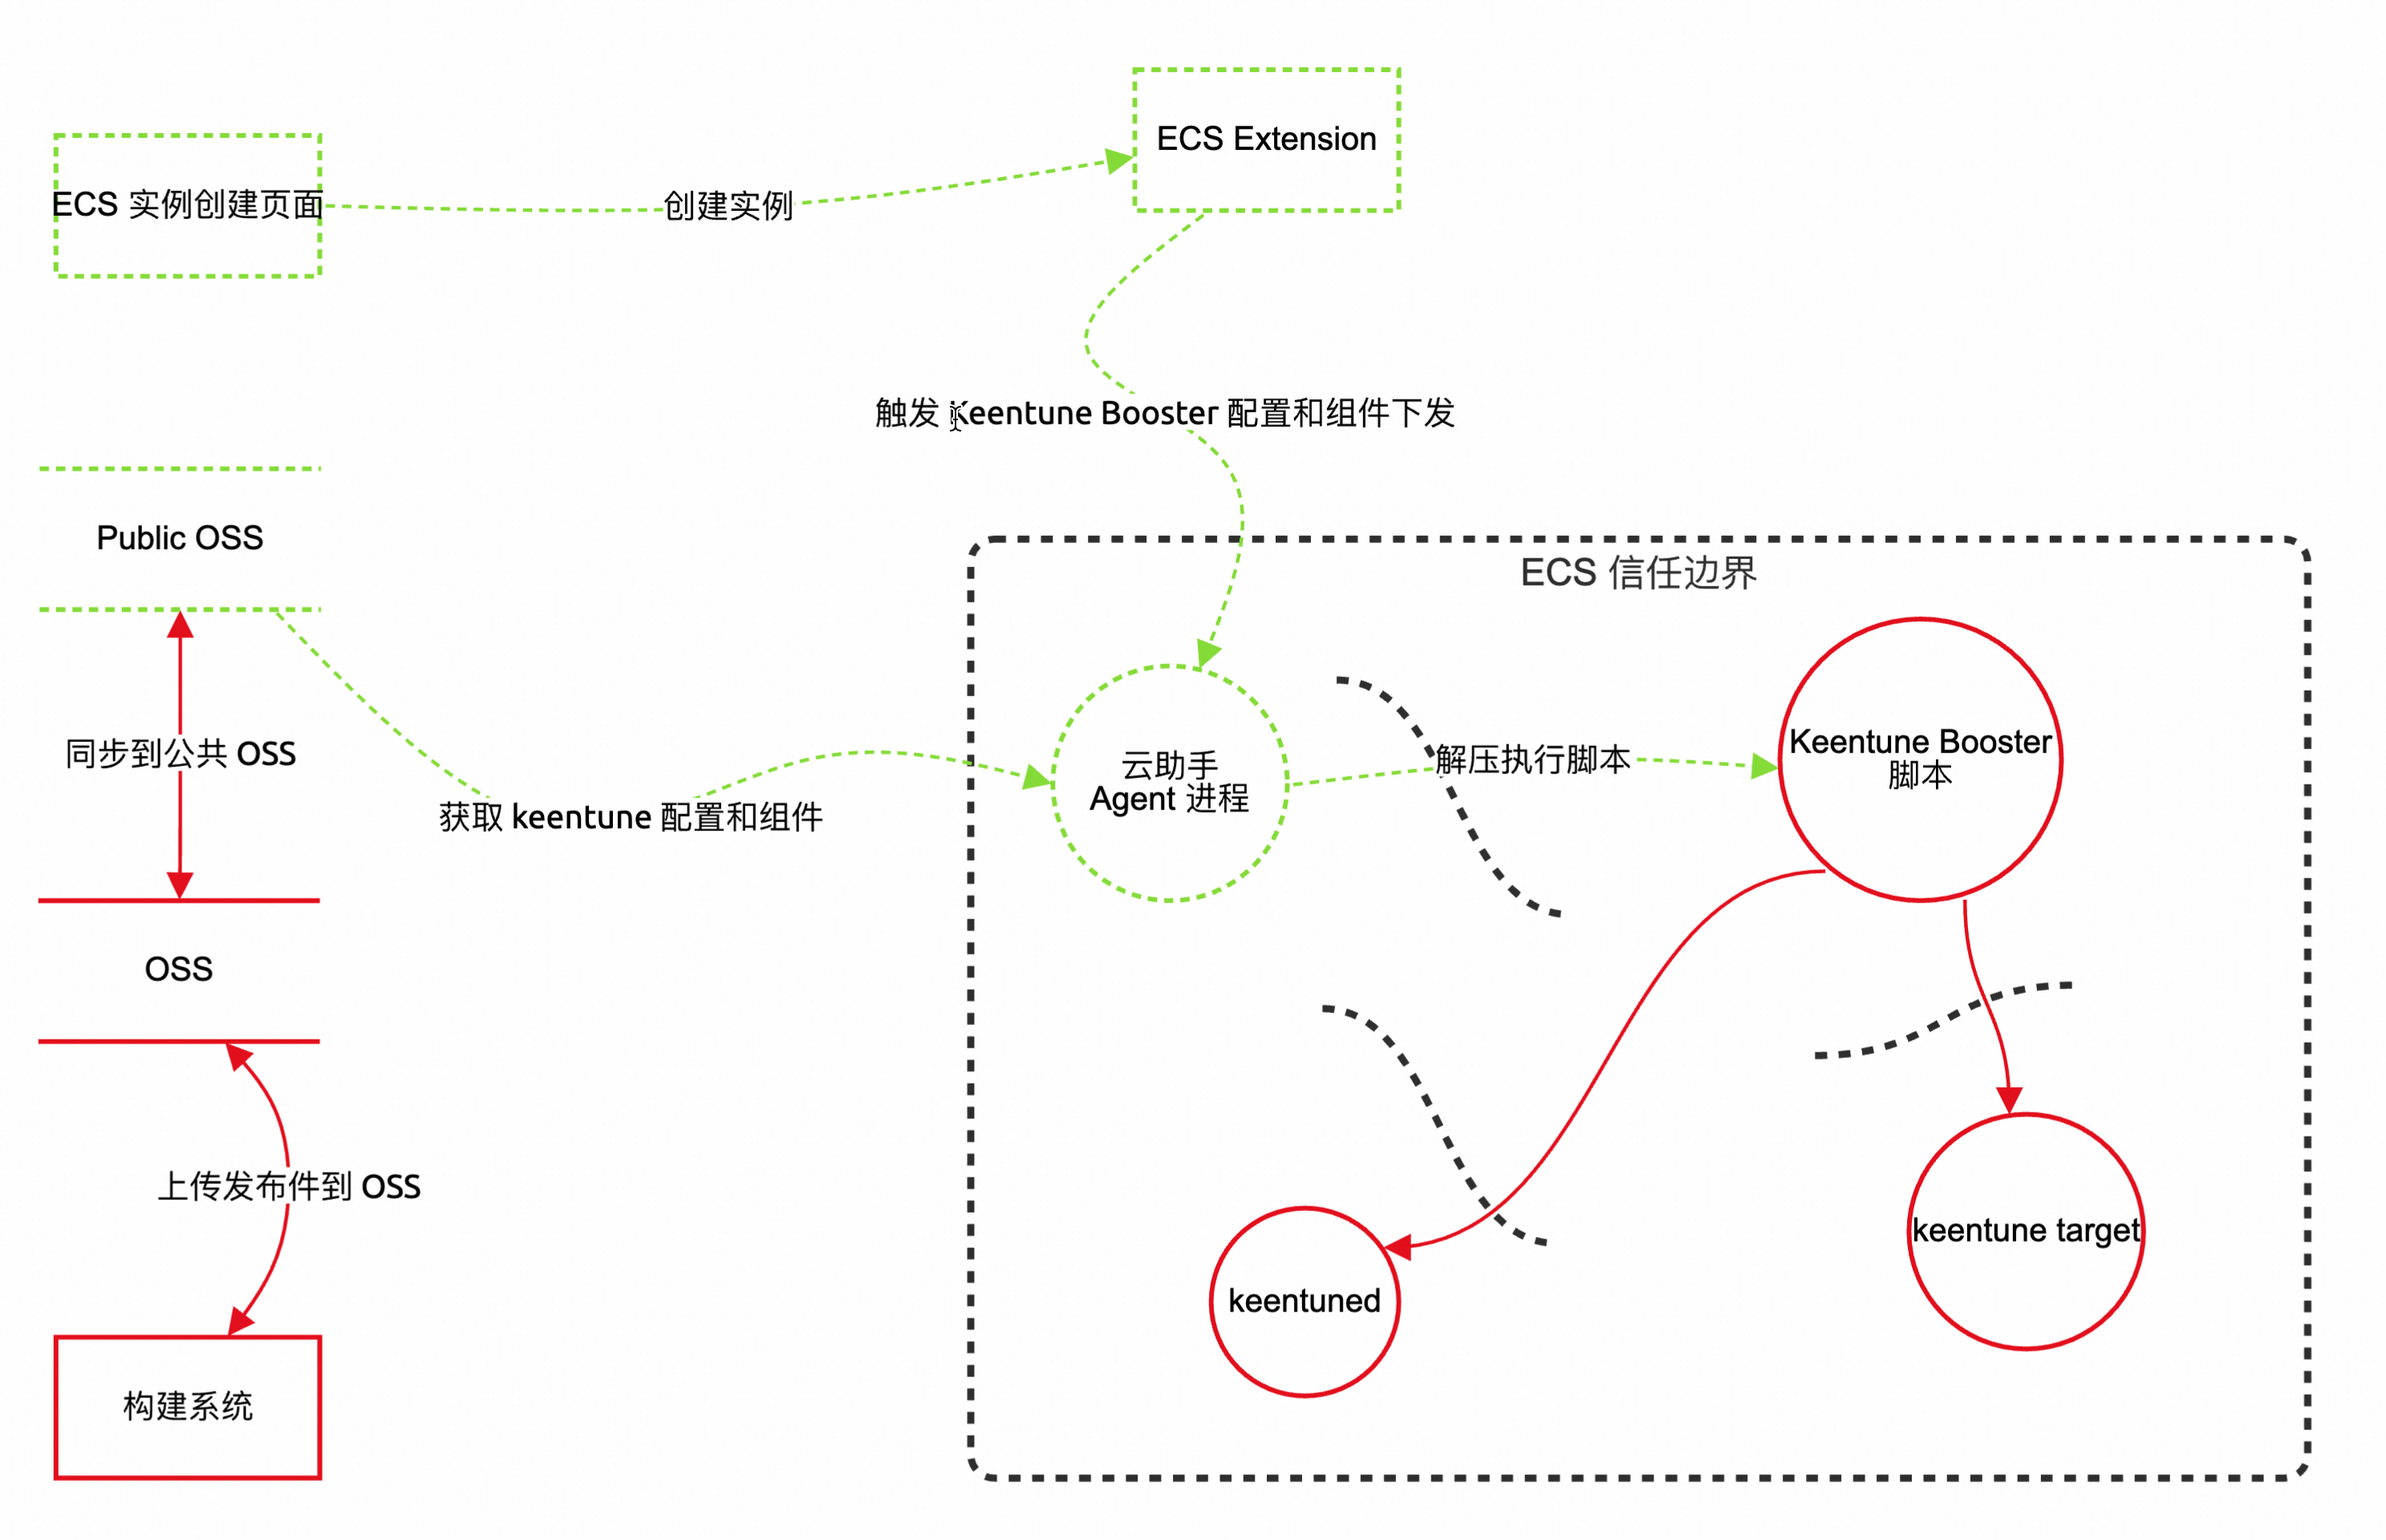

```json
[
    {
        "type": "process",
        "id": "1",
        "name": "ECS 实例创建页面",
        "description": "创建 ECS 实例的页面",
        "position": "top-left"
    },
    {
        "type": "process",
        "id": "2",
        "name": "ECS Extension",
        "description": "ECS 扩展组件",
        "position": "top-center"
    },
    {
        "type": "process",
        "id": "3",
        "name": "云助手 Agent 进程",
        "description": "云助手 Agent 进程",
        "position": "center-left"
    },
    {
        "type": "process",
        "id": "4",
        "name": "Keentune Booster 脚本",
        "description": "Keentune Booster 脚本",
        "position": "center-right"
    },
    {
        "type": "process",
        "id": "5",
        "name": "keentuned",
        "description": "keentuned 进程",
        "position": "bottom-center"
    },
    {
        "type": "process",
        "id": "6",
        "name": "keentune target",
        "description": "keentune 目标",
        "position": "bottom-right"
    }

In [31]:
from http import HTTPStatus
import dashscope
import os
import json
from IPython.display import Image

img = Image(filename="./devops-datas/Keentune-STRIDE-Model.png", width=640)
display(img)


def stride_threat_model_analysis():
    """threat model architecture analysis."""
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "image": "https://raw.githubusercontent.com/edonyzpc/Mentis/refs/heads/master/prompts/devops-datas/Keentune-STRIDE-Model.png"
                },
                {
                    "text": """
图片是一个 data flow diagram（数据流图），图中包括的元素有：
1.圆圈表示进程（process）；
2.带箭头的线段表示数据流（flow）；
3.矩形表示外部实体（actor）；
4.上下实线边框表示数据存储（data）；
5.没有箭头虚线表示信任边界（trust-boundary-curve）；
6.虚线矩形表示信任边界（trust-boundary-box)；

元素之间关系：
1.元素之间通过箭头表示数据流，箭头方向表示数据流方向；
2.元素之间通过虚线框表示信任边界，表示元素之间不涉及数据流，但需要通信；

你的任务是帮我识别图片中的元素和相互之间的关系，要求你输出一个json，格式如下：
```[
    {
        type: "process",
        id: <uuid for the element>,
        name: <name for the element>,
        description: <description for the element>,
        position: <position for the element>,
    },
    {
        type: "actor",
        id: <uuid for the element>,
        name: <name for the element>,
        description: <description for the element>,
        position: <position for the element>,
    },
    {
        type: "data",
        id: <uuid for the element>,
        name: <name for the element>,
        description: <description for the element>,
        position: <position for the element>,
    },
    {
        type: "trust-boundary-curve",
        id: <uuid for the element>,
        name: <name for the element>,
        description: <description for the element>,
        position: <position for the element>,
    },
    {
        type: "trust-boundary-box",
        id: <uuid for the element>,
        name: <name for the element>,
        description: <description for the element>,
        position: <position for the element>,
    },
    {
        type: "flow",
        id: <uuid for the element>,
        name: <name for the element>,
        description: <description for the element>,
        position: <position for the element>,
        "source": {
            "cell": <source element id of the data flow>,
        },
        "target": {
            "cell": <target element id of the data flow>,
        }
    }
]```"""
                },
            ],
        }
    ]
    response = dashscope.MultiModalConversation.call(
        model="qwen-vl-max", messages=messages, api_key=os.getenv("DASHSCOPE_API_KEY"),
    )
    # The response status_code is HTTPStatus.OK indicate success,
    # otherwise indicate request is failed, you can get error code
    # and message from code and message.
    if response.status_code == HTTPStatus.OK:
        print(response.output.choices[0].message.content[0]['text'])
        obj = json.loads(
            response.output.choices[0].message.content[0]["text"].strip("```json")
        )
        print(len(obj))
    else:
        print(response.code)  # The error code.
        print(response.message)  # The error message.


if __name__ == "__main__":
    stride_threat_model_analysis()

In [28]:
## prompt for scanning the code to find the weakness
with open("./code-scan.md", "r") as f:
    code_scan = f.read()

code_scan_template = ChatPromptTemplate.from_template(code_scan)
print(code_scan_template.input_variables)

with open("./sourcecode-datas/keentune-bench-system.py", "r") as f:
    code = f.read()

language = "python"
display(Markdown(f"```python\n{code}\n```"))

code_scan_response = (code_scan_template | llm | StrOutputParser()).invoke({"code": code, "language": language})


display(Markdown(code_scan_response))

['code', 'language']


```python
# Copyright (c) 2021-2023 Alibaba Cloud Computing Ltd.
# SPDX-License-Identifier: MulanPSL-2.0
import json
import requests
import subprocess
import logging

logger = logging.getLogger("common")


def proc_alive(pid):
    """
    Check if a specific process is alive

    Args:
        pid (int): The process ID

    Returns:
        bool: True if the process is alive, False otherwise
    """
    try:
        os.kill(pid, 0)
        return True
    except:
        return False


def httpResponse(response_data, response_ip, response_port):
    """
    Send HTTP response.

    Args:
        response_data (dict): The response data.
        response_ip (str): The IP address to send the response to.
        response_port (int): The port to send the response to.

    Returns:
        None

    Raises:
        None
    """
    logger.info(
        "send response to {ip}:{port}:{data}".format(
            ip=response_ip, port=response_port, data=response_data
        )
    )
    try:
        requests.post(
            url="http://{ip}:{port}/benchmark_result".format(
                ip=response_ip, port=response_port
            ),
            data=json.dumps(response_data),
            timeout=3,
        )
    except requests.exceptions.ConnectTimeout:
        logger.warning(
            "send response timeout: ip = {}, port = {}".format(
                response_ip, response_port
            )
        )


def sysCommand(command: str, cwd: str = "./"):
    """
    Execute a system command and return the execution result.

    Parameters:
    command: str - The command to be executed.
    cwd: str - Optional. The current working directory (default is current directory "./").

    Returns:
    suc: bool - Indicates whether the command was executed successfully.
    out: str - Standard output result when the command is executed successfully.
    error: str - Error information when the command fails to execute.
    """
    result = subprocess.run(
        command,
        shell=True,
        close_fds=True,
        cwd=cwd,
        stderr=subprocess.PIPE,
        stdout=subprocess.PIPE,
    )

    suc = result.returncode == 0
    out = result.stdout.decode("UTF-8", "strict").strip()
    error = result.stderr.decode("UTF-8", "strict").strip()

    if not suc:
        return suc, error
    else:
        return suc, out


def checkAddressAvaliable(address_list: list):
    """
    Check the availability of IP addresses.

    Args:
        address_list (list): List of IP addresses.

    Returns:
        dict: Dictionary containing IP addresses and availability results.
    """
    result = {}
    for ip in address_list:
        logger.debug("ping -W 1 -c 1 {}".format(ip))
        try:
            suc, _ = sysCommand("ping -W 1 -c 1 {ip}".format(ip=ip))
            if not suc:
                logger.warning("Failed to ping {}".format(ip))
            else:
                logger.debug("Success to ping {}".format(ip))
            result[ip] = suc

        except Exception as e:
            logger.error("fail to ping {}: {}".format(ip, e))
            result[ip] = False

    return result

```

After reviewing the provided Python code, I've identified several potential security vulnerabilities and provided recommendations to address them.

### 1. Insecure Deserialization (JSON)

**Vulnerability**: The `httpResponse` function serializes `response_data` into JSON using `json.dumps()` without validating its contents. Maliciously crafted input could lead to data injection or object injection if deserialized elsewhere in the application.

**Recommendation**: Validate `response_data` before serialization to ensure it only contains expected keys and value types. Use a schema validation library like `jsonschema` to enforce this.

### 2. Command Injection (`sysCommand` Function)

**Vulnerability**: The `sysCommand` function executes system commands based on user-provided `command` strings without proper sanitization. This can lead to command injection where an attacker could inject arbitrary system commands.

**Recommendation**: Avoid using `shell=True` whenever possible to prevent shell interpretation of arguments. Use list-based arguments for `subprocess.run()` to pass command and its parameters separately. Additionally, sanitize inputs and use whitelisting approaches for allowed commands or parameters.

### 3. Information Leakage (`proc_alive` Function)

**Vulnerability**: The `proc_alive` function attempts to check process liveness by sending a signal (0), which may leak information about running processes to unauthorized users if the PID is predictable or guessable.

**Recommendation**: Implement access controls to ensure this function is only used within trusted contexts or consider alternative ways to verify process status that do not rely on direct OS signals.

### 4. Lack of Input Validation (`checkAddressAvaliable` Function)

**Vulnerability**: The `checkAddressAvaliable` function blindly formats IP addresses into system commands without thorough validation. Although the function primarily pings addresses, a malformed or specially crafted IP could potentially lead to unexpected behavior or command injection.

**Recommendation**: Implement strict validation for IP addresses to ensure they adhere to valid IPv4 or IPv6 formats before using them in system commands.

### 5. Logging Sensitive Data

**Vulnerability**: While not directly visible in the provided code snippets, the use of `logger.info()` to log HTTP responses in `httpResponse` could potentially expose sensitive data if `response_data` includes such information.

**Recommendation**: Ensure logging does not include sensitive data. Implement a mechanism to filter or mask sensitive information before logging.

### 6. Unhandled Exceptions

**Vulnerability**: In `checkAddressAvaliable`, while there's a broad `except` block to catch exceptions when pinging addresses, it simply logs the error without further handling. Depending on the context, unhandled exceptions can lead to service disruption or information disclosure.

**Recommendation**: Consider adding more granular exception handling to identify specific errors and handle them appropriately, potentially with retries, alerts, or graceful degradation of service.

Implementing these recommendations will significantly enhance the security posture of the application by mitigating common vulnerabilities and ensuring safer handling of data and system interactions.